# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">2 hours</span>
* 2. Part B: <span style="color:red;">15 minutes</span>
* 3. Part C: <span style="color:red;">30 minutes</span>
* 4. Part D: <span style="color:red;">6 hours</span>
* 5. Write-up: <span style="color:red;">30 minutes</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

### Load our images

In [1]:
%pylab inline
import cv2
from skimage.transform import warp
from PIL import Image
import numba

Populating the interactive namespace from numpy and matplotlib


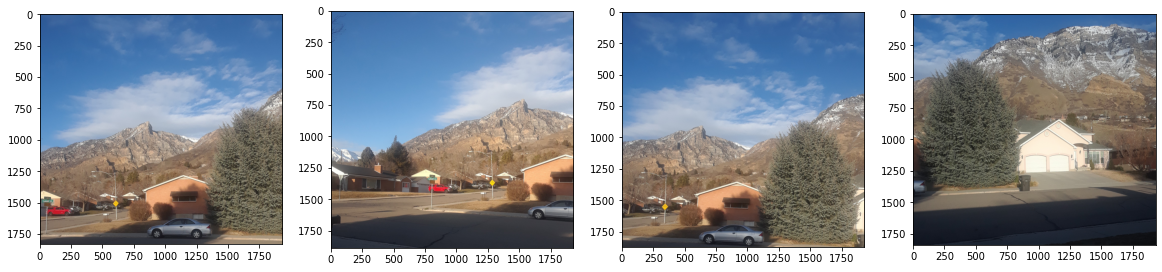

In [2]:
images = [asarray(Image.open(image_location))
          for image_location in (
              "user_provided/1.jpg",
              "user_provided/2.jpg",
              "user_provided/3.jpg",
              "user_provided/4.jpg"
          )
    ]
ax, fig = subplots(1, 4, figsize=(20, 5))
for i in range(4):
    fig[i].imshow(images[i])

### Part A: Find Interest Points/Descriptors

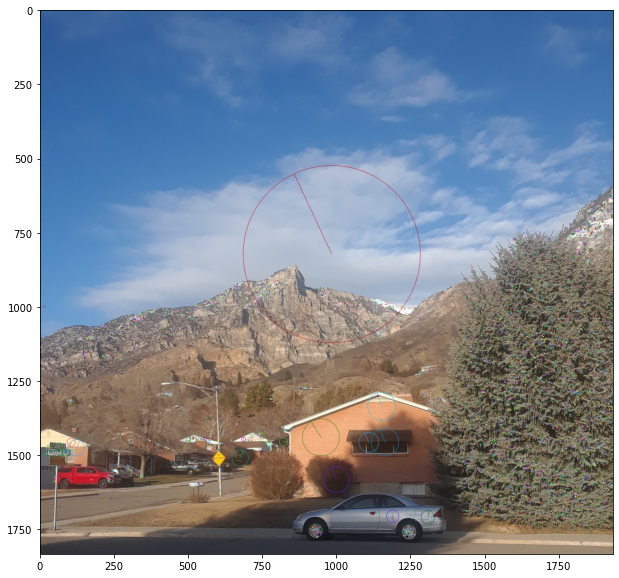

In [3]:
def get_keypoints_and_descriptors(gray_image, nfeatures=150):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures)
    return sift.detectAndCompute(gray_image, None)


gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
kps, dess = [], []
for image in gray_images:
    kp, des = get_keypoints_and_descriptors(image, nfeatures=5000)
    kps.append(kp)
    dess.append(des)
    
# Display key points for our base image:
kp = kps[0]
base_image = images[0].copy()
display_image = cv2.drawKeypoints(base_image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = figure(figsize=(25, 10))
imshow(display_image)

### Part B: Matching Features

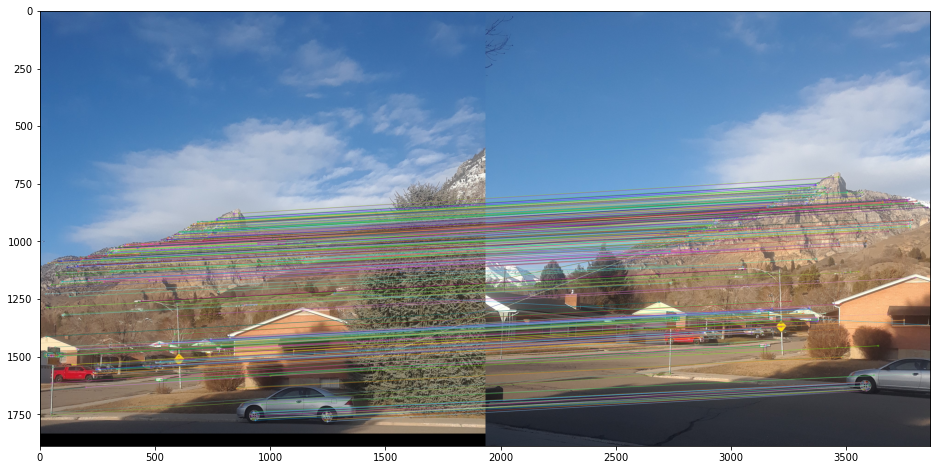

In [4]:
def get_matches(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_L2SQR, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2) # Get best two matches for each descriptor
    good = []
    for one, two in matches:
        if one.distance < two.distance * 0.56:
            good.append([one])
    return good

matches = [get_matches(dess[0], des) for des in dess[1:]]

# Display matches between our base image and another image:
kp1, kp2 = kps[:2]
match = matches[0]
base_image = images[0].copy()
other_image = images[1].copy()
display_image = cv2.drawMatchesKnn(base_image, kp1, other_image, kp2, match, None, flags=2)

fig = figure(figsize=(25, 8))
imshow(display_image)

### Part C: Estimating Pairwise Homographies using RANSAC

In [5]:
def four_point_algorithm(start_points, end_points):
    """
    Usage:  computes a homography of start points to end points.  Each must be a list of at least 4 points. If
            the number of points is greater than 4, a least squares solution will be returned.
    """
    start_point, end_point = start_points[0], end_points[0]
    A = np.concatenate([[
        [start_point[0], start_point[1], 1, 0, 0, 0, -end_point[0]*start_point[0], -end_point[0]*start_point[1]],
        [0, 0, 0, start_point[0], start_point[1], 1, -end_point[1]*start_point[0], -end_point[1]*start_point[1]]
    ] for start_point, end_point in zip(start_points, end_points)])
    
    b = np.concatenate([[x, y] for x, y in end_points])[None].T
    
    if b.size != 8:
        A, b = np.matmul(A.T, A), np.matmul(A.T, b)
    
    H = np.matmul(np.linalg.inv(A), b)
    H = np.append(H, 1)
    H = H.reshape((3, 3))
    
    return H

def random_selection(start_points, end_points, count=4):
    """
    Choose a random number of the start / end points
    """
    indices = numpy.random.choice(range(len(start_points)), size=count, replace=False)
    return start_points[indices], end_points[indices]

def transform(H, points):
    padded = ones([3, len(points)])
    padded[:2] = points.T
    new_points = (H @ padded)
    new_points = new_points / new_points[2][None, :]
    return new_points[:2].T

def compute_homography(kp1, kp2, matches, count=500, error=5):
    """
    Use RANSAC and the Four Point Algorithm to find the best homography between the two.
    """
    
    all_start_points = []
    all_end_points = []
    
    for match in matches:
        all_start_points.append(kp1[match[0].queryIdx].pt)
        all_end_points.append(kp2[match[0].trainIdx].pt)
    
    all_start_points, all_end_points = asarray(all_start_points), asarray(all_end_points)
    
    best = -1
    best_consensus_set = None
    
    for _ in range(count):
        start_points, end_points = random_selection(all_start_points, all_end_points)
        try:
            H = four_point_algorithm(start_points, end_points)
        except np.linalg.LinAlgError:
            # Ignore singular matrix errors
            continue
        transformed = transform(H, all_start_points)
        diff = np.sum(np.square(transformed - all_end_points), axis=1)
        
        consensus_set = [i for i in range(len(diff)) if diff[i] < error]
        if len(consensus_set) > best:
            best = len(consensus_set)
            best_consensus_set = consensus_set
    
    print("Best size of consensus set: " + str(best))
    
    return four_point_algorithm(all_start_points[best_consensus_set], all_end_points[best_consensus_set])

In [6]:
homographies = [compute_homography(kps[0], kps[i+1], matches[i], error=10) for i in range(len(images) - 1)]
for H in homographies:
    print()
    print(H)

Best size of consensus set: 363
Best size of consensus set: 1207
Best size of consensus set: 717

[[ 8.02471762e-01  7.72239125e-02  6.70603527e+02]
 [-1.50849676e-01  1.03787911e+00 -1.09066745e+02]
 [-1.28122870e-04  5.16897527e-05  1.00000000e+00]]

[[ 1.13135238e+00 -8.08182369e-02 -2.16714681e+02]
 [ 1.54854127e-01  1.03838575e+00 -8.77443752e+01]
 [ 6.72238424e-05 -1.67326337e-05  1.00000000e+00]]

[[ 2.36393913e+00  6.79740637e-02 -3.14015392e+03]
 [ 6.24090238e-01  2.30456268e+00 -2.02845046e+03]
 [ 5.53176452e-04  1.53898688e-04  1.00000000e+00]]


### Part D: Creating the Mosaic

In [7]:
def get_corners(image):
    return array([
        [0, 0],
        [image.shape[1], 0],
        [image.shape[1], image.shape[0]],
        [0, image.shape[0]]
    ])

def compute_edges(points, buffer=0):
    return [min(point[0] for point in points) - buffer,
            min(point[1] for point in points) - buffer,
            max(point[0] for point in points) + buffer,
            max(point[1] for point in points) + buffer]

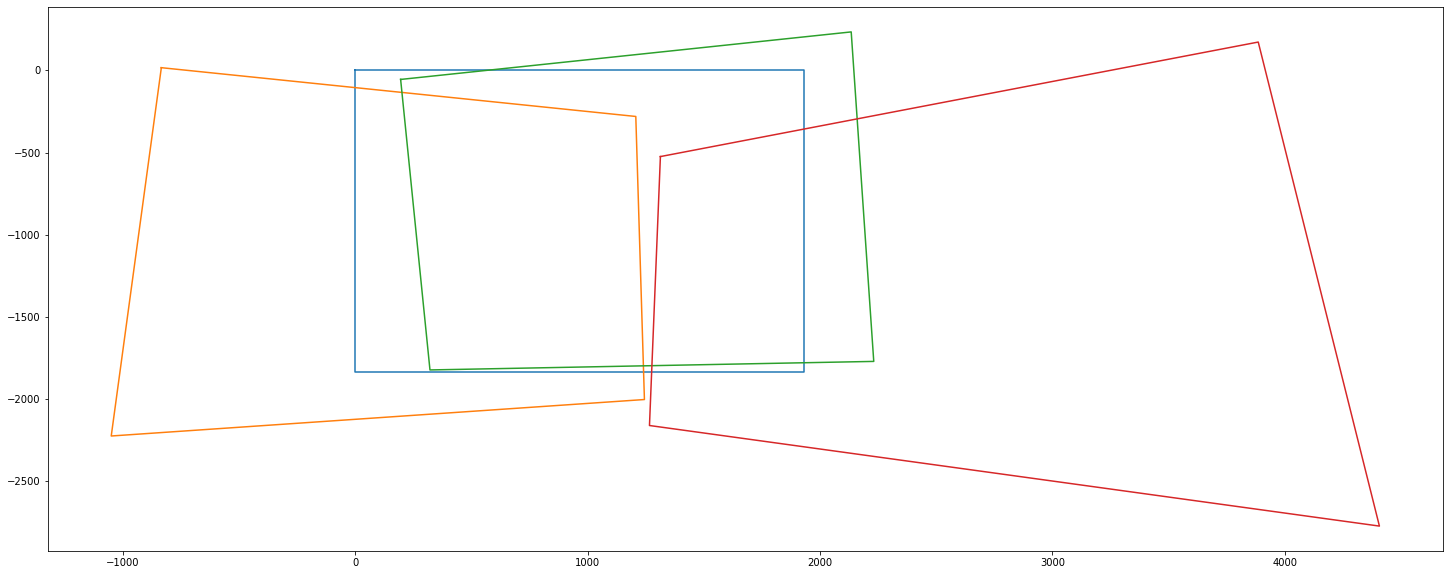

In [8]:
corners = [get_corners(image) for image in images]
warped_corners = [corners[0]] + [transform(np.linalg.inv(homographies[i]), corner) for i, corner in enumerate(corners[1:])]
edges = compute_edges([point for corner in warped_corners for point in corner])

fig = figure(figsize=(25, 10))
for i, corner in enumerate(warped_corners):
    corner = np.append(corner, [corner[0]], axis=0)
    x, y = corner[:, 0], -corner[:, 1]
    plot(x, y)

In [9]:
# Shift our homographies in such a way that they will all map to positive values
shift = array([
    [1, 0, -edges[0]],
    [0, 1, -edges[1]],
    [0, 0, 1]
])
shifted_homographies = [np.matmul(H, np.linalg.inv(shift)) for H in homographies]
final_shape = (int(ceil(edges[3] - edges[1])), int(ceil(edges[2] - edges[0])))

In [10]:
# Warp our images
warped_base = warp(images[0], np.linalg.inv(shift), output_shape = final_shape)
warped_images = [warped_base] + [warp(image, H, output_shape = final_shape) for image, H in zip(images[1:], shifted_homographies)]

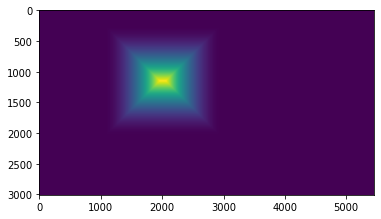

In [11]:
# Create masks
import numba
centers = [sum(warped_corner, axis=0)/4 - edges[0:2] for warped_corner in warped_corners]
y, x = range(final_shape[0]), range(final_shape[1])
xx, yy = np.meshgrid(x, y)
sigma = 500

@numba.njit()
def create_mask(image_shape):
    height, width = image_shape[:2]
    result = zeros((height, width))
    for y in range(height):
        for x in range(width):
            result[y][x] = min((x + 1, y + 1, width - x, height - y))**2
    return result
    
masks = [create_mask(image.shape) for image in images]
masks = [warp(masks[0], np.linalg.inv(shift), output_shape = final_shape)] + [warp(mask, H, output_shape = final_shape) for mask, H in zip(masks[1:], shifted_homographies)]

imshow(masks[0])

c:\users\camac\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


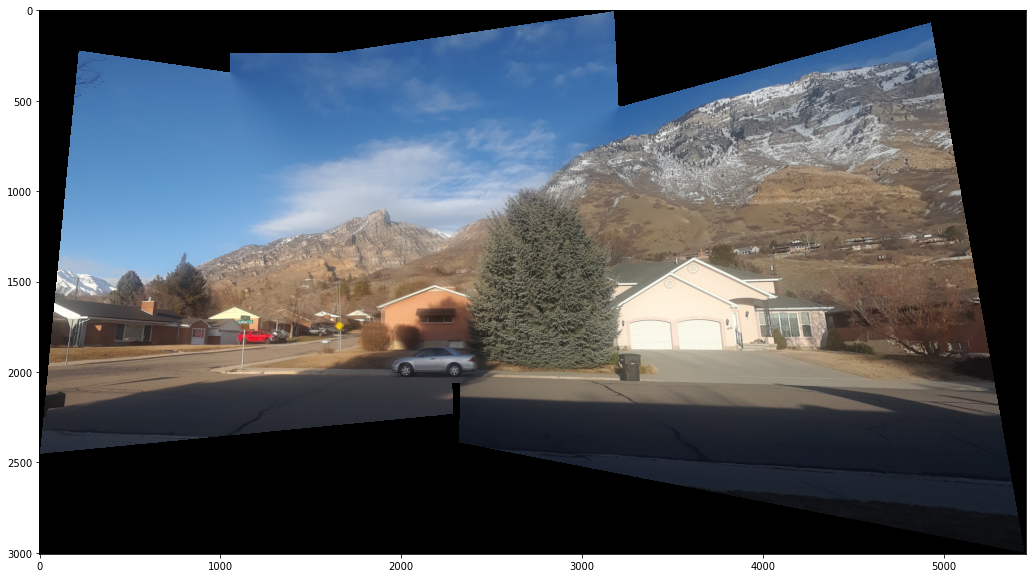

In [12]:
result = zeros(final_shape + (3,))
for warped_image, mask in zip(warped_images, masks):
    result = result + warped_image * mask[:, :, None]
result = result / sum(masks, axis=0)[:, :, None]

fig = figure(figsize=(25, 10))
imshow(result)

### Final Results and Improvements

In [13]:
result[result > 1] = 1
result = (result * 255).astype(uint8)
image = Image.fromarray(result)
image.save("final_result.png")

c:\users\camac\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

I did the following to create a panorama:
 1. Compute keypoints and descriptors using OpenCV's SIFT detector.
 2. Find pairs of matches using OpenCV's knn brute force matcher as outlined in the tutorial above.
 3. Use RANSAC and the four point algorithm to compute homography matrices.  Note that in the final step of RANSAC, I used the entire consensus set to compute the final homography matrix, using a least squares algorithm.
 4. Shift each homography matrix so that the warped values will be positive
 5. Composite the warped images together in a way the producees little to no artifacts
  - To do this, I took a weighted average for each pixel.  The weight corresponding to a pixel for a certain image was the distance squared of that pixel to the closest edge.  This made a smooth blending from one image to another.
  
Sometimes it was hard to get good alignments between images.  I encountered this when there was little overlap between the images or I had shifted the camera, inducing parallax.